# ROC analysis

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from scipy.stats import norm
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
plt.rcParams.update({'font.size':16,'figure.figsize':(12,8)})

In [2]:
def animated_roc():
    fig_anim,ax = plt.subplots(1,2,figsize=(10,4))
    feature = np.linspace(5,33,1000)
    sick = norm.pdf(feature,23,3)
    healthy = norm.pdf(feature,15,3)
    ax[0].plot(feature,healthy,label='Healthy')
    ax[0].plot(feature,sick,label='Sick')
    line = ax[0].plot([5,5],[0,0.15],'--')[0]
    ax[0].set_xlabel('Feature Value')
    ax[0].set_ylabel('Probability Density')
    ax[0].legend()
    tpr = 1
    fpr = 1
    scat = ax[1].scatter([],[],s=50,color='red')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlim(-0.02,1.02)
    ax[1].set_ylim(-0.02,1.02)
    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    thresholds = np.linspace(5,33,50)
    
    def update(threshold):
        fpr = 1-norm.cdf(threshold,15,3)
        tpr = 1-norm.cdf(threshold,23,3)
        line.set_xdata([threshold,threshold])
        history = ax[1].scatter([fpr],[tpr],s=10,color='black')
        scat.set_offsets([fpr,tpr])

    return fig_anim,update,thresholds

<IPython.core.display.Javascript object>


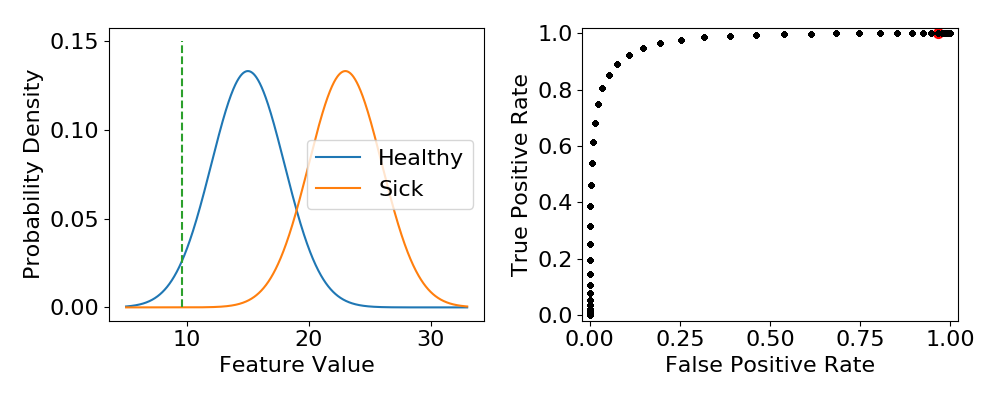

In [3]:
fig_anim,update,thresholds = animated_roc()
anim = FuncAnimation(fig_anim,update,thresholds)

In [4]:
# Create instance of these classes
rfc = RandomForestClassifier(oob_score=True)

In [5]:
df = pd.read_csv('data/article_ephys_metadata_curated.csv',delimiter='\t').set_index('Index')

In [6]:
target = 'NeuronName'

predictors = ['PubYear', 'BrainRegion', 'Species', 'Strain', 'ElectrodeType', 'PrepType', 'JxnPotential', 
              'JxnOffset', 'RecTemp', 'AnimalAge', 'AnimalWeight', 'external_0_Mg', 'external_0_Ca', 
              'external_0_Na', 'external_0_Cl', 'external_0_K', 'external_0_pH', 'internal_0_Mg', 
              'internal_0_Ca', 'internal_0_Na', 'internal_0_Cl', 'internal_0_K', 'internal_0_pH', 
              'rin', 'rmp', 'apthr', 'apamp', 'aphw', 'tau', 'ahpamp', 'cap', 'apwidth', 'apfreq', 'rheo', 
              'ahpdur', 'sagratio', 'maxfreq', 'apriseslope', 'fahpamp', 'spontfreq', 'appeak', 'apriset', 
              'apdecayslope', 'apdelay', 'fislope', 'adratio', 'apamprest', 'sagamp', 'sahpamp', 
              'apdecayt', 'accres', 'adratioinv', 'adpamp', 'ahpamprest', 'mahpamp', 'fahpdur', 'ahpvolt', 
              'sahpdur', 'celldiam', 'adpctother', 'adpct', 'adpctminus', 'surfarea', 'mahpdur', 
              'adratiominus', 'adpctinv', 'adpdur', 'fahpvolt', 'mahpamprest', 'apamptrough', 
              'sahpamprest', 'fahpamprest', 'sahpvolt', 'mahpvolt']

numerical_predictors = ['PubYear', 'RecTemp', 'rin', 'rmp', 'apthr', 'apamp', 'aphw', 'tau']
categorical_predictors = ['BrainRegion', 'Species', 'Strain', 'ElectrodeType', 'PrepType']

df_predictors = df[numerical_predictors+categorical_predictors]
df_target = df[target]

In [7]:
df_predictors = pd.get_dummies(df_predictors)
df_predictors = df_predictors.fillna(df_predictors.mean())

In [8]:
top_10_cell_types = list(df_target.value_counts(normalize=True).index)[:10]
top_10_cell_type_indices = df_target.isin(top_10_cell_types)
df_target = df_target.loc[top_10_cell_type_indices]
df_predictors = df_predictors[top_10_cell_type_indices]

In [9]:
# Initialize the classification algorithm (Random Forest Classification)
rfc = RandomForestClassifier(n_estimators=100,oob_score=True)

In [10]:
#predictions = cross_val_predict(rfc, df_predictors, df_target)
df_is_pyramidal = df_target == 'Neocortex pyramidal cell layer 5-6'
rfc.fit(df_predictors,df_is_pyramidal);

## Computed on in-sample predictions

In [11]:
predicted_classes = rfc.predict_proba(df_predictors)
predicted_classes

array([[0.97      , 0.03      ],
       [0.98333333, 0.01666667],
       [0.97      , 0.03      ],
       ...,
       [0.13      , 0.87      ],
       [0.96      , 0.04      ],
       [0.99      , 0.01      ]])

In [12]:
prob_pyramidal = predicted_classes[:,1]

In [13]:
fpr, tpr, thresholds = roc_curve(df_is_pyramidal, prob_pyramidal)

In [14]:
auc = roc_auc_score(df_is_pyramidal, prob_pyramidal)

In [15]:
plt.rcParams.update({'font.size':16,'figure.figsize':(8,6)})

In [16]:
def plot_roc(fpr,tpr):
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC analysis')
    ax.legend(loc="lower right");

<IPython.core.display.Javascript object>


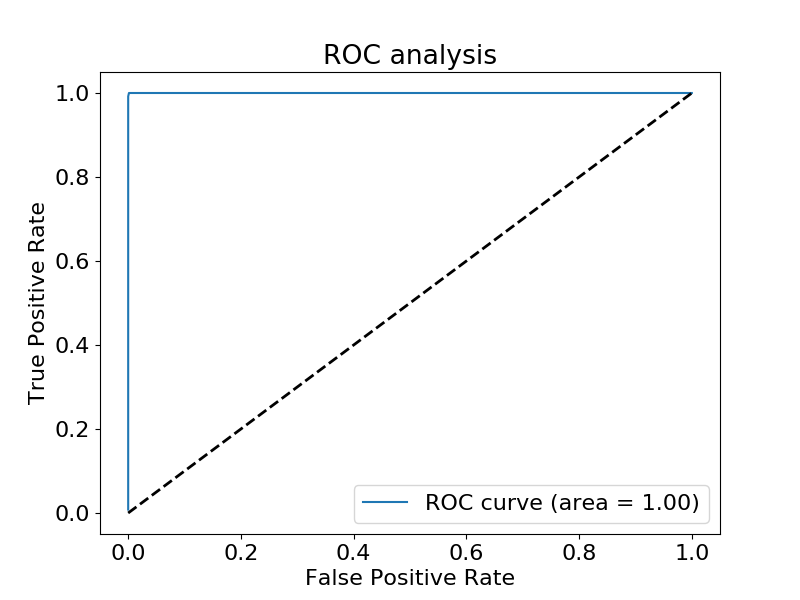

In [17]:
plot_roc(fpr,tpr)

## Computed on out-of-sample predictions

In [18]:
predicted_classes = cross_val_predict(rfc, df_predictors, df_is_pyramidal, method='predict_proba')
prob_pyramidal = predicted_classes[:,1]
fpr, tpr, thresholds = roc_curve(df_is_pyramidal, prob_pyramidal)
auc = roc_auc_score(df_is_pyramidal, prob_pyramidal)

<IPython.core.display.Javascript object>


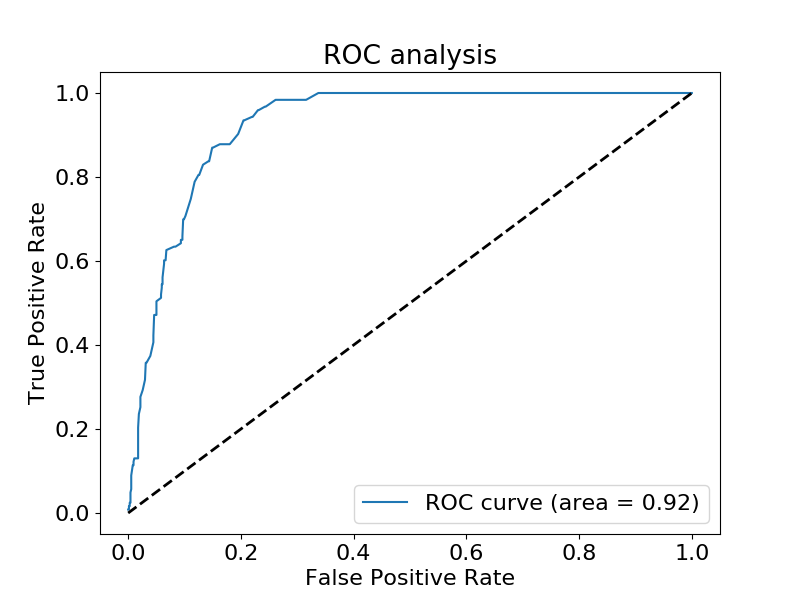

In [19]:
plot_roc(fpr,tpr)